# Predicting functional capabilities of MAGs

In [1]:
import pandas as pd
import numpy as np
import re
from math import *

#scikit-learn modules
from sklearn import ensemble, linear_model, metrics
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#plotting
from matplotlib import pyplot as plt
from matplotlib import style
style.use('ggplot')

%matplotlib inline

clades = ['Kingdom','Phylum','Class','Order','Family','Genus','Species']

import warnings
warnings.filterwarnings('ignore')

## Training a set of classifiers

In [3]:
#load in necessary data files as before

ko_matrix = pd.read_csv('datafiles/taxid_ko_matrix_all_full.csv').drop('Unnamed: 0',1)
func_matrix = pd.read_csv('datafiles/groups_to_records_all_full.txt',sep='\t', comment='#')

ko_matrix.columns = [re.sub('ko:','',i) for i in ko_matrix.columns]

#get lists of the KOs and functions for later use
ko_list = [i for i in list(ko_matrix.columns) if i.startswith('K')]
func_list = func_matrix.drop('record',1).columns

In [4]:
#merge the two files together based on the column 'species_taxid'
merged = pd.merge(ko_matrix, func_matrix, left_on='species_taxid', right_on='record')

merged.head()

,species_taxid,K00001,K00002,K00003,K00004,K00005,K00007,K00008,K00009,K00010,...,anoxygenic_photoautotrophy,oxygenic_photoautotrophy,photoautotrophy,aerobic_anoxygenic_phototrophy,photoheterotrophy,phototrophy,plastic_degradation,ureolysis,reductive_acetogenesis,chemoheterotrophy
0,562,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2188,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,38289,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,134821,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,632,0,0,0,0,0,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = merged[ko_list]
y = merged[func_list]
support = y.sum()

As a final preprocessing step, we need to normalize the features for logistic regression. We scale them so that all features have zero mean and unit variance. Note that we learn the means and variances from the training data only.

Now we train a classifier as before, except that now we train one for each function and save the results, along with accuracy measures.

In [5]:
#loop through all the functions, save classifiers and accuracy

clf_dict = {} #dictionary to keep the trained classifiers
acc_dict = {} #dictionary with the classification accuracy for each function
sc_dict = {}

print('Training...')

for func in y.columns:
    
    if support[func]>=5: #only do function with at least 5 positive examples
        
        print(func)
    
        y_i = y[func]

        X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y_i,stratify=y_i)
        
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        #clf = linear_model.LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
        clf = svm.SVC(kernel='linear', probability=True, C=0.005)
        clf.fit(X_train,y_train)

        prob_tr = [i[1] for i in clf.predict_proba(X_train)]
        prob_test = [i[1] for i in clf.predict_proba(X_test)]

        pred_tr = [1 if i>0.5 else 0 for i in prob_tr]
        pred_test = [1 if i>0.5 else 0 for i in prob_test]

        clf_dict[func] = clf
        sc_dict[func] = sc
        
        #print out the results as we go
        try:
            acc_dict[func] = (metrics.roc_auc_score(y_test,prob_test),
                             metrics.f1_score(y_test,pred_test),
                             support[func])
            
        except: #may throw up errors if no positive predictions
            acc_dict[func] = 'err'

methanotrophy
acetoclastic_methanogenesis
methanogenesis_by_disproportionation_of_methyl_groups
methanogenesis_using_formate
methanogenesis_by_CO2_reduction_with_H2
methanogenesis_by_reduction_of_methyl_compounds_with_H2
hydrogenotrophic_methanogenesis
methanogenesis
methanol_oxidation
methylotrophy
aerobic_ammonia_oxidation
aerobic_nitrite_oxidation
nitrification
sulfate_respiration
sulfur_respiration
dark_sulfite_oxidation
sulfite_respiration
thiosulfate_respiration
respiration_of_sulfur_compounds
arsenate_detoxification
arsenate_respiration
dissimilatory_arsenate_reduction
arsenite_oxidation_detoxification
dissimilatory_arsenite_oxidation
anammox
nitrate_denitrification
nitrite_denitrification
nitrous_oxide_denitrification
denitrification
chitinolysis
knallgas_bacteria
dark_hydrogen_oxidation
nitrogen_fixation
nitrate_ammonification
nitrite_ammonification
nitrite_respiration
cellulolysis
xylanolysis
dark_sulfide_oxidation
dark_sulfur_oxidation
dark_thiosulfate_oxidation
dark_oxidati

In [6]:
acc_df = pd.DataFrame(acc_dict).T
acc_df.columns = ['AUROC score', 'F1 score', '# of positive examples']
acc_df['# of positive examples'] = acc_df['# of positive examples'].astype(int)
acc_df.loc['nitrate_reduction']

AUROC score                  0.893837
F1 score                     0.705667
# of positive examples    1275.000000
Name: nitrate_reduction, dtype: float64

## Histogram of number of features used in the predictors

In [10]:
df = []

for func in y.columns:
    try:
        coefs = clf_dict[func].coef_[0]
        num_nonzero = sum(abs(coefs)>0)
        df.append((func,num_nonzero,acc_dict[func][0], acc_dict[func][2]))
        
    except KeyError:
        pass
    
df = pd.DataFrame(df)
df.columns = ['function','n_genes','AUROC','support']
df.head()

,function,n_genes,AUROC,support
0,methanotrophy,20,0.995250,61
1,acetoclastic_methanogenesis,4,0.499787,7
2,methanogenesis_by_disproportionation_of_methyl...,5,1.000000,32
3,methanogenesis_using_formate,11,0.999681,8
4,methanogenesis_by_CO2_reduction_with_H2,15,0.999616,75


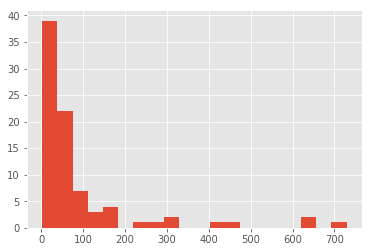

In [11]:
df.n_genes.hist(bins=20)

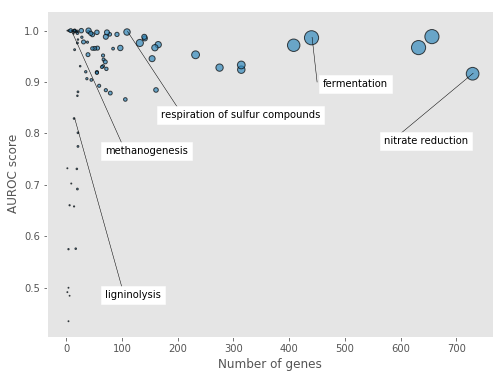

In [12]:
min_pointsize=5
max_pointsize=1000

max_pointsize = max_pointsize - min_pointsize

df['pointsize'] = df['support'] * max_pointsize / df['support'].max()# + min_pointsize

#have a ceiling on pointsize
df['pointsize'] = df['pointsize'].apply(lambda x: 200 if x>200 else x)

df.plot(kind='scatter',x='n_genes',y='AUROC', s=df['pointsize'],
       alpha=0.7, lw=1, edgecolor='k', grid=False, figsize=(8,6))

plt.xlabel('Number of genes')
plt.ylabel('AUROC score')

def make_label(func_name,text_pos,label_shift):

    point_pos = list(df.set_index('function').loc[func_name][['n_genes','AUROC']])
    point_pos[0] = point_pos[0] + 1
    point_pos[1] = point_pos[1] + 0.001
    
    plt.plot([text_pos[0],point_pos[0]],[text_pos[1],point_pos[1]], 'k-', lw=0.5)
    
    text_pos = [i+j for i,j in zip(text_pos,label_shift)]
    plt.text(*text_pos,re.sub('_',' ',func_name),backgroundcolor='w')

make_label('fermentation',(450,0.9),(10,-0.01))
make_label('nitrate_reduction',(600,0.8),(-30,-0.02))
make_label('respiration_of_sulfur_compounds',(200,0.85),(-30,-0.02))
make_label('methanogenesis',(100,0.78),(-30,-0.02))
make_label('ligninolysis',(100,0.5),(-30,-0.02))


Make an interactive graph of the above so can look at which functions are which

# Cross validation

We now use a technique called k-fold cross-validation, where the data is repeatedly split into different test and training sets, such that every data point is in the training set in one of the 'folds'. This will allow us to get a better estimate of our classifier's accuracy, since we're using all of the data we have to train the model.

In [8]:
#defining a custom metric
def max_kappa(true,probs):
    
    def get_kappa(cutoff):
        preds = [1 if i>cutoff else 0 for i in probs]
        return metrics.cohen_kappa_score(true,preds)
    
    kappas = [get_kappa(i) for i in np.arange(0,1,0.01)]
    return max(kappas),np.argmax(kappas)*0.01

In [9]:
cv_acc_dict = {}
X = np.array(X)

for func in y.columns:
    
    try:
    
        skf = model_selection.StratifiedKFold(n_splits=5,shuffle=True)
        
        #pipeline with feature scaling and clf

        sc = StandardScaler()
        #lr = linear_model.LogisticRegression(penalty='l1',solver='liblinear',C=0.05,
        #                                    class_weight='balanced')
        lr = ensemble.RandomForestClassifier()
        sv = svm.SVC(kernel='linear', probability=True, C=0.005)

        scaling_plus_lr = Pipeline([('scaling', sc), ('log_reg', sv)])
        
        y_i = y[func]
        y_i = np.array(y_i)

        probs = model_selection.cross_val_predict(scaling_plus_lr,
                                                  X,y_i,cv=skf,method='predict_proba')
        probs = [i[1] for i in probs]
        preds = [1 if i>0.5 else 0 for i in probs]
        cv_acc_dict[func] = ( metrics.roc_auc_score(y_i,probs),
                             metrics.cohen_kappa_score(y_i,preds), max_kappa(y_i,probs)[0] )
        
    except:
        cv_acc_dict[func] = 'err'

Plot these accuracies

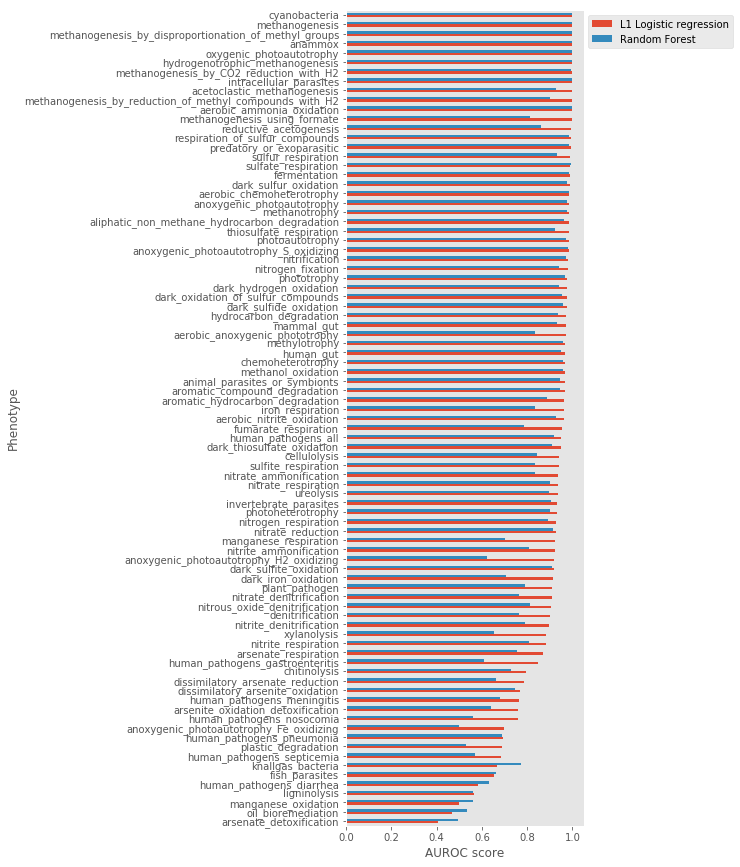

In [37]:
def force_float(x):
    try:
        return float(x)
    except:
        return np.nan

acc_df = acc_df.applymap(force_float)
acc_df = acc_df[acc_df['AUROC score']>0]
acc_df.index.name = 'Phenotype'
acc_df = acc_df.sort_values('AUROC score',ascending=True)
acc_df[['AUROC score']].plot(kind='barh', grid=False,
                                                figsize=(10,15))
plt.xlabel('AUROC score')
l = plt.legend(loc=1, bbox_to_anchor=(1.65,1), labels=['L1 Logistic regression','Random Forest'])
plt.gcf().subplots_adjust(right=0.78, left=0.45)
